# Probe selection of AIBS
To be run after the sample selection.

In this step we retain or exclude gene expression probes from the AIBS datasets. We will be using the re-annotated probes using our Re-annotator software (link here) which already prepared for a previous paper: Richiardi et al. (2015). We will use folling parameters for filtering:

* exclude probes that were measuring multiple genes
* exclude probes that were not mapped to a gene
* exclude probes with low expression across the dataset.


In [2]:
import os, sys
import numpy as np
import pandas as pd
import scipy.spatial
#import nipy
#import nibabel as nib
import math
import feather
from scipy.stats import t, spearmanr, norm, wilcoxon, mannwhitneyu, ttest_ind
import matplotlib
from matplotlib.pyplot import scatter
from statsmodels.sandbox.stats.multicomp import multipletests
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd, eig

In [3]:
#some useful functions

#3d scatter plots (for point clouds)
def quickPlot3DBrain(X,Y,Z, cv='b', angle=[0,90]):
    fig = matplotlib.pyplot.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, s=2, c=cv)
    ax.view_init(angle[0], angle[1])
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.grid(False)
    
    matplotlib.pyplot.show()

#find substrings
def FindAnySubstring(mystr, sublist):
    for s in sublist:
        if mystr.find(s) > -1:
            return True
    return False

#small function to derive the number of genes being tagged
def GetUniqueGene(mystr):
    tok = mystr.strip().split(' ')
    tok_set = set(tok)
    return(list(tok_set))

def CheckUniqueGene(mystr):
    genes = GetUniqueGene(mystr)
    return len(genes) == 1

In [4]:
#some options
AIBS_path='/Users/andre/work/Data/AIBS/'
donors=['H0351_1009','H0351_1012', 'H0351_1015', 'H0351_1016', 'H0351_2001', 'H0351_2002']
selected_samples_file = "selected_samples_lh_for_FTD_AIBS.csv"

In [5]:
sample_info = pd.read_csv(selected_samples_file, index_col=0)
sample_info.head()

,well_id,structure_id,slab_num,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z,corrected_mni_x,corrected_mni_y,corrected_mni_z,sampleID,probe2label,probe2dist
0,10964,4023,2,CX,SFG-m,"superior frontal gyrus, left, medial bank of g...",1266467,96,55,47,-5.0,44.0,54.0,-4.456913,42.626309,53.306473,H0351_1009,192,0.000000
1,10965,4039,2,CX,trIFG,"inferior frontal gyrus, triangular part, left",1266555,128,113,44,-37.0,47.0,-4.0,-37.014483,42.918867,-0.301717,H0351_1009,206,1.000000
2,10966,4051,3,CX,MOrG,"medial orbital gyrus, left",1265851,100,137,59,-9.0,32.0,-28.0,-9.535526,30.015430,-24.276204,H0351_1009,148,0.000000
3,10972,4224,2,CX,CgGf-i,"cingulate gyrus, frontal part, left, inferior ...",1266689,96,110,46,-5.0,45.0,-1.0,-5.445986,42.277137,1.581663,H0351_1009,102,0.000000
4,10973,4024,3,CX,SFG-l,"superior frontal gyrus, left, lateral bank of ...",1265853,114,63,62,-23.0,29.0,46.0,-18.855630,25.569178,43.817038,H0351_1009,192,1.414214


In [6]:
#re-annotated probes
reannotator = pd.read_csv( os.path.join(AIBS_path, 'AIBS_probe2gene_reannotator.txt'), sep='\t', names=["probe_name","Genes"])
reannotator.head()

,probe_name,Genes
0,A_23_P100001,FAM174B
1,A_23_P100011,AP3S2 C15orf38-AP3S2 AP3S2 AP3S2
2,A_23_P100022,SV2B SV2B
3,A_23_P100056,RBPMS2
4,A_23_P100074,AVEN


In [7]:
#in this section we are loading the AIBS data
did=donors[0]
probe_info=pd.read_csv( os.path.join(AIBS_path, did, 'Probes.csv.gz') )

GE_file = os.path.join(AIBS_path, "GE.feather")
PA_file = os.path.join(AIBS_path, "PA.feather")


In [8]:
#if we have stored them as .feather files, skip this step.
if not os.path.exists(GE_file):
    sys.stderr.write("reading source files into data frame\n")

    GE=pd.DataFrame()
    PA=pd.DataFrame()
    for did in donors:
        sys.stderr.write("working on donor: " + did + "\n" )
        si_tmp = pd.read_csv( os.path.join(AIBS_path, did, 'SampleAnnot.csv.gz') )
        cnames = ['probe_id']
        cnames.extend(si_tmp.well_id.tolist())
        ge_tmp = pd.read_csv( os.path.join(AIBS_path, did, 'MicroarrayExpression.csv.gz'), names=cnames)
        pa_tmp = pd.read_csv( os.path.join(AIBS_path, did, 'PACall.csv.gz'), names=cnames)
        if GE.shape == (0,0):
            GE = GE.append(ge_tmp)
            PA = PA.append(pa_tmp)
        else:
            GE = pd.merge(GE, ge_tmp, on="probe_id")
            PA = pd.merge(PA, pa_tmp, on="probe_id")

    feather.write_dataframe(GE, GE_file )
    feather.write_dataframe(PA, PA_file )
else:
    sys.stderr.write("reading feather files into data frame\n")

    GE = feather.read_dataframe(GE_file)
    PA = feather.read_dataframe(PA_file)


reading feather files into data frame


In [22]:
pidx_unique = reannotator.Genes.apply(CheckUniqueGene)
probe_rm_names = ['dist=',',']
#probe_rm_names = [',']
pidx_inter   = ~reannotator.Genes.apply(FindAnySubstring, args=[probe_rm_names])


In [25]:
sum(pidx_inter & pidx_unique)

50598

In [26]:
reanno_keep = reannotator[pidx_inter & pidx_unique]
#use_probes 
probe_info_keep = probe_info.merge(reanno_keep)

In [27]:
PA.set_index('probe_id', inplace=True)
GE.set_index('probe_id', inplace=True)
probe_info_keep = probe_info_keep.set_index('probe_id')

In [28]:
##find probes with low expression
pa_tmp = PA.loc[probe_info_keep.index, sample_info.well_id.apply(str)]
print(pa_tmp.shape)
pa_expr = pa_tmp.apply(sum, axis=1)
#pidx_minexpr = pa_tmp.apply(sum, axis=1) >= min_expr


(49113, 1248)


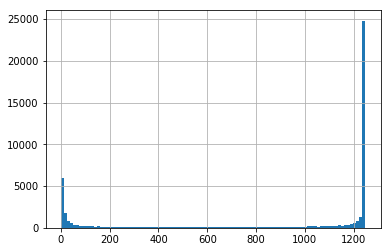

In [29]:
pa_expr.hist(bins=100)

In [30]:
def probes2genes(plist):
    tmp=plist.Genes.apply(GetUniqueGene).values
    tmp2=[]
    for x in tmp:
        tmp2.append(x[0])
    return(list(set(tmp2)))

In [31]:
for i in [200, 300, 600, 900, 1100]:
    print(str(i) + " " + str(sum(pa_expr>=i)))
    print(str(i) + " " + str(len(probes2genes(probe_info_keep[pa_expr>i]))))

200 37551
200 17064
300 36657
300 16772
600 34512
600 16103
900 32251
900 15412
1100 29888
1100 14677


In [27]:
GE_use = GE.loc[probe_info_keep[pa_expr>=300].index, sample_info.well_id.apply(str)]
GE_use.shape

(36657, 1248)

In [28]:
probes_for_analysis = probe_info_keep[pa_expr>=300]
probes_for_analysis.to_csv("./probes_for_analysis.csv")

## Continue here with analysis


In [143]:
def my_corrcoef(x, y):
    #x may contain missing values
    mynull = pd.isnull(x)
    #print(mynull.head())
    #print(x.head())
    #print(y.head())
    #res = np.corrcoef(x[~mynull], y[~mynull])
    res = spearmanr(x[~mynull], y[~mynull])
    return(res[0])

def getPvalue(meas, perm):
    if meas > 0:
        return(sum(perm >= meas)/len(perm))
    else:
        return(sum(perm <= meas)/len(perm))

In [144]:
ftd_gene = "MAPT"

#load img_values
image_values = pd.read_csv("image_values_permutation_"+ftd_gene+".csv", index_col=0)

In [209]:
probe_name = "A_24_P278460"

In [210]:
probe_id = probe_info[probe_info.probe_name == probe_name].probe_id

In [211]:
tmp = GE_use.loc[probe_id, image_values.index.astype(str)].transpose()

In [212]:
tmp.set_index(image_values.index, inplace=True)

In [213]:
tmp2 = image_values.apply(lambda x: my_corrcoef(x, tmp.iloc[:,0]), axis=0)


In [214]:
getPvalue(tmp2[1], tmp2[2:])

0.006

In [215]:
tmp2

original     -0.121682
unpermuted   -0.112666
spin_1       -0.019078
spin_2        0.060610
spin_3       -0.034019
spin_4       -0.027176
spin_5       -0.007994
spin_6        0.030186
spin_7        0.043236
spin_8        0.084368
spin_9       -0.044162
spin_10      -0.087951
spin_11       0.004808
spin_12      -0.079740
spin_13      -0.041513
spin_14      -0.013843
spin_15       0.037019
spin_16       0.002218
spin_17      -0.059608
spin_18       0.064964
spin_19       0.010277
spin_20      -0.074462
spin_21      -0.014475
spin_22       0.049020
spin_23      -0.026432
spin_24      -0.052932
spin_25       0.091118
spin_26       0.025503
spin_27      -0.043384
spin_28      -0.024945
                ...   
spin_971      0.102009
spin_972      0.017674
spin_973      0.078638
spin_974     -0.049980
spin_975      0.011099
spin_976     -0.043936
spin_977      0.006407
spin_978     -0.024021
spin_979     -0.036957
spin_980     -0.066134
spin_981     -0.056356
spin_982     -0.029072
spin_983   